# CALF interactive testing

In [1]:
import logging
import os
from pathlib import Path


import datacube
import fiona
import geopandas
import ipywidgets as widgets
import numpy as np
import rasterio
import rasterio.features
import rasterio.transform
import rasterio.windows
import rioxarray
import rioxarray.crs
import rioxarray.merge
import xarray as xr
from datacube.utils import geometry as dc_geometry
from IPython.display import display

from calf import calf

# this is a minor detail, toning down third-party loggers
logging.basicConfig(level=logging.DEBUG)
for logger_name in ("datacube", "fiona", "matplotlib", "pyproj", "rasterio"):
    logging.getLogger(logger_name).setLevel(logging.WARNING)


## Initial processing

In this section we create a new datacube client, then proceed to load the region of interest and crop mask files. These auxiliary files are intersected in order to give us a set of features to focus on during the analysis.

For didatic purposes we then focus on the first intersected feature - the real CALF algorithm processor (see below) is able to handle the analysis for all features.

In [2]:
dc = datacube.Datacube(
    app="test-calf-interactive",
    env="sandbox",
    config=os.getenv("DATACUBE_CONFIG_PATH")
)

roi_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg"), layer="region-of-interest")
crop_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg", layer="crop-mask"))

intersected_df = geopandas.overlay(
    roi_df, 
    crop_df.to_crs(epsg=roi_df.crs.to_epsg()),  # reprojecting on-the-fly 
    how="intersection", 
    keep_geom_type=True
)
intersected_df

test_series1 = intersected_df.iloc[0]

# lets select the series that uses parcel3
test_series2 = intersected_df.query("name_1 == 'municipality1' & name_2 == 'parcel3'").iloc[0]

test_series = test_series2

base_query = {
    "time": ("2015-01-01", "2021-12-31"),
    "measurements": ["red", "nir", "spclass"],
    "output_crs": "EPSG:32635",
    "resolution": (-10, 10),
    "resampling": "cubic",
    "geopolygon": dc_geometry.Geometry(
        test_series.geometry.__geo_interface__,
        dc_geometry.CRS(f"EPSG:{intersected_df.crs.to_epsg()}")
    ),
    "product": "test_spot7_gauteng_old_eo3",
}

ds = dc.load(**base_query)
ds

/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<xarray.Dataset>
Dimensions:      (time: 2, x: 24, y: 36)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) int16 947 860 1008 1070 1021 ... 959 951 975 981
    nir          (time, y, x) int16 2182 2221 2489 2332 ... 1752 1308 1219 1179
    spclass      (time, y, x) uint8 69 70 70 58 68 70 70 ... 58 43 21 20 20 20
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

In [3]:
test_series["name_1"]

'municipality1'

## Apply quality flags to mask out bad pixels

The `ds` variable now holds an `xarray.Dataset` with the ARd data that we want to work with. We move on by selecting only those pixels that have good quality

In [4]:
valid_ds = calf.apply_validity_mask(ds, "spclass")
valid_ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 24, y: 36)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float64 947.0 860.0 1.008e+03 ... 975.0 981.0
    nir          (time, y, x) float64 2.182e+03 2.221e+03 ... 1.179e+03
    spclass      (time, y, x) float64 69.0 70.0 70.0 58.0 ... 20.0 20.0 20.0
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

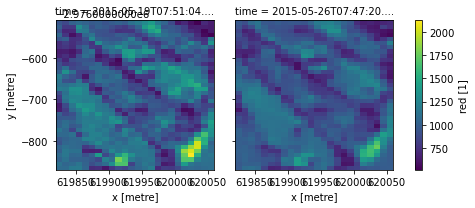

In [5]:
valid_ds.red.plot(col="time")

## Rasterize and apply crop mask

In order to perform the CALF analysis only on the relevant crop area, we convert the intersected feature (which is an intersection of the region of interest with the crop mask) into a 2d array and then use it as a mask. Values falling outside of the crop area are assigned a value of `np.nan`.

In [ ]:
crop_mask_da = calf.rasterize_feature(valid_ds, test_series2)
crop_mask_da

In [ ]:
crop_mask_da.plot()

Applying the crop mask to our dataset

In [ ]:
crop_ds = valid_ds * crop_mask_da
crop_ds

In [ ]:
crop_ds.red.plot(col="time")

### Calculate individual and seasonal (i.e. aggregated) NDVI

In [ ]:
ndvi_da = (crop_ds.nir - crop_ds.red) / (crop_ds.nir + crop_ds.red)
ndvi_da

In [ ]:
ndvi_da.plot(col="time")

Calculating the aggregated NDVI by using **Greenest Pixel Method** - which is just a matter of taking the pixelwise maximum value for the temporal series

In [ ]:
aggregated_ndvi_da = ndvi_da.max(dim="time")
aggregated_ndvi_da

In [ ]:
aggregated_ndvi_da.plot()

Now we discard those pixels that show an NDVI below the vegetation threshold - **FIXME: need to check if those are to be assigned some special value**

In [ ]:
aggregated_vegetation_ndvi_da = aggregated_ndvi_da.where(aggregated_ndvi_da > 0.2)
aggregated_vegetation_ndvi_da

In [ ]:
aggregated_vegetation_ndvi_da.plot()

## Compute CALF
Calculate the statistical measurements needed for the CALF calculation and then calculate the raw CALF and the reclassified one

In [ ]:
mean = aggregated_vegetation_ndvi_da.mean()
std_dev = aggregated_vegetation_ndvi_da.std()
mean, std_dev

calf_da = (aggregated_vegetation_ndvi_da - mean) / std_dev
calf_da.rio.write_crs("epsg:32635", inplace=True)
calf_da

In [ ]:
calf_da.plot()

In [ ]:
reclassified_calf_da = xr.where(calf_da <= 1, 1, 0).astype(np.uint8) * crop_mask_da

In [ ]:
reclassified_calf_da.plot()

## Calculate statistics

In [ ]:
counts, frequencies = np.unique(reclassified_calf_da, return_counts=True)

num_fallow_pixels = int(frequencies[counts == 0])
num_planted_pixels = int(frequencies[counts == 1])
total_pixels = int((~np.isnan(reclassified_calf_da)).sum())
print(f"fallow: {num_fallow_pixels}, planted: {num_planted_pixels}, total: {total_pixels}")

In [ ]:
reclassified_calf_da.rio.to_raster("calf_parcel3.tif")